# Stock Market Prediction Univariate Recurrent Neural Networks

## Veri Çekme

In [2]:
!pip install yfinance

In [15]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import seaborn as sns

In [16]:
stockname = "Amazon"
symbol = "AMZN"
start_date = "2000-01-01"
end_date = str(date.today())
today = date.today()

In [19]:
import yfinance as yf 
df = yf.download(start=start_date,end =end_date,tickers =symbol, interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [18]:
df_year = yf.download(start=start_date,end =end_date,tickers =symbol, interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [20]:
print(df.shape)
df.head(5)

(5762, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00-05:00,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04 00:00:00-05:00,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05 00:00:00-05:00,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06 00:00:00-05:00,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07 00:00:00-05:00,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [21]:
print(df_year.shape)
df_year.head(5)

(5762, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00-05:00,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04 00:00:00-05:00,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05 00:00:00-05:00,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06 00:00:00-05:00,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07 00:00:00-05:00,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


## Veri Görselleştirme

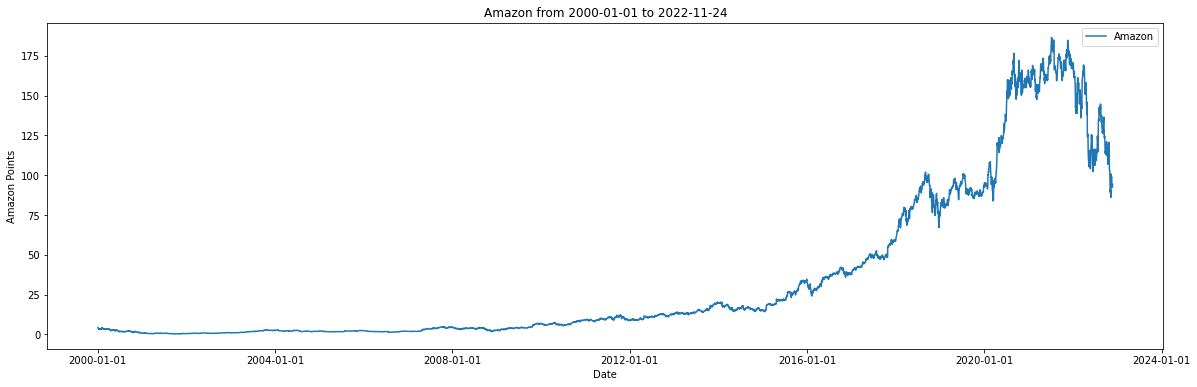

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.legend([stockname], fontsize=15)
plt.title(stockname + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['Close'], label=stockname, linewidth=1.5)
plt.ylabel('Amazon Points')
plt.show()

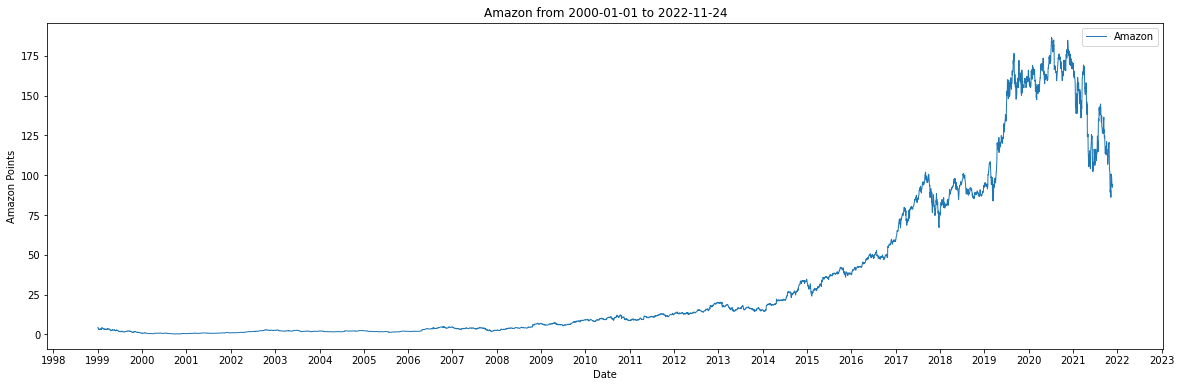

In [23]:
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ '2000-01-01' + ' to ' + end_date)
sns.lineplot(data=df_year['Close'], label=stockname, linewidth=1.0)
plt.ylabel('Amazon Points')
plt.show()

## Veri Normalizasyonu(Ölçeklendirme)

In [24]:
train_df = df.filter(['Close'])
data_unscaled = train_df.values

In [25]:
train_data_length = math.ceil(len(data_unscaled) * 0.8)

In [26]:
train_data_length

4610

In [27]:
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [28]:
np_data

array([[0.02238796],
       [0.02039155],
       [0.01712013],
       ...,
       [0.49476841],
       [0.49874108],
       [0.50373378]])

## Girdiyi Düzenleme

Eğitime başlamadan veri setimizi train ve test olarak ayırmamız gerekiyor.Bu sayede test kısmı ile veriyi test edeceğiz.
Daha sonra ise son 1 haftanın 1'er saatlik verisine göre (yani ortalama 50 veri) bir sonraki saati tahmin etmeye çalışacağız.

In [29]:
index_Close = train_df.columns.get_loc("Close")
print(index_Close)

0


In [30]:
train_data_len = math.ceil(np_data.shape[0] * 0.8)

In [31]:
train_data_len

4610

In [32]:
sequence_length = 50
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [33]:
train_data[:10],test_data[:10]

(array([[0.02238796],
        [0.02039155],
        [0.01712013],
        [0.0159961 ],
        [0.0170698 ],
        [0.01696914],
        [0.01631485],
        [0.01545925],
        [0.01609676],
        [0.01564379]]),
 array([[0.38726166],
        [0.3925389 ],
        [0.39644984],
        [0.3970994 ],
        [0.40103452],
        [0.40692646],
        [0.40425024],
        [0.40437639],
        [0.39927634],
        [0.40110161]]))

In [34]:
train_df.shape[0]

5762

In [35]:
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) 
        y.append(train_df[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

In [36]:
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [37]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4560, 50, 1) (4560,)
(1152, 50, 1) (1152,)


In [38]:
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0.4231151263795404
0.4231151263795404


In [39]:
x_train[:2]

array([[[0.02238796],
        [0.02039155],
        [0.01712013],
        [0.0159961 ],
        [0.0170698 ],
        [0.01696914],
        [0.01631485],
        [0.01545925],
        [0.01609676],
        [0.01564379],
        [0.01561024],
        [0.01633163],
        [0.015778  ],
        [0.01505661],
        [0.01722078],
        [0.01698591],
        [0.01579478],
        [0.01636518],
        [0.01495595],
        [0.01572767],
        [0.01649939],
        [0.01703624],
        [0.02099551],
        [0.01948562],
        [0.01852936],
        [0.02071031],
        [0.01993858],
        [0.01884811],
        [0.01884811],
        [0.01837837],
        [0.0182106 ],
        [0.01737177],
        [0.01691881],
        [0.015778  ],
        [0.01545925],
        [0.01730467],
        [0.01676782],
        [0.01695236],
        [0.01604643],
        [0.01688525],
        [0.01607998],
        [0.01519082],
        [0.01517405],
        [0.01555991],
        [0.01544247],
        [0

## Model

In [40]:
model = Sequential()

neurons = sequence_length

model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
285/285 [==============================] - 8s 20ms/step - loss: 3.1910e-04
Epoch 2/25
285/285 [==============================] - 6s 20ms/step - loss: 3.2103e-05
Epoch 3/25
285/285 [==============================] - 6s 20ms/step - loss: 3.0450e-05
Epoch 4/25
285/285 [==============================] - 6s 20ms/step - loss: 2.4689e-05
Epoch 5/25
285/285 [==============================] - 6s 20ms/step - loss: 2.4544e-05
Epoch 6/25
285/285 [==============================] - 6s 20ms/step - loss: 2.1964e-05
Epoch 7/25
285/285 [==============================] - 6s 20ms/step - loss: 2.3793e-05
Epoch 8/25
285/285 [==============================] - 6s 20ms/step - loss: 2.7112e-05
Epoch 9/25
285/285 [==============================] - 6s 20ms/step - loss: 1.6243e-05
Epoch 10/25
285/285 [==============================] - 6s 20ms/step - loss: 1.7709e-05
Epoch 11/25
285/285 [==============================] - 6s 20ms/step - loss: 1.6594e-05
Epoch 12/25
285/285 [==============================]

## Prediction

In [42]:
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

36/36 [==============================] - 1s 11ms/step


In [43]:
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 3.97
Mean Absolute Percentage Error (MAPE): 2.91 %
Median Absolute Percentage Error (MDAPE): 2.63 %


In [44]:
train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={'Close': 'x_train'})
train

,x_train
Date,
2000-01-03 00:00:00-05:00,4.468750
2000-01-04 00:00:00-05:00,4.096875
2000-01-05 00:00:00-05:00,3.487500
2000-01-06 00:00:00-05:00,3.278125
2000-01-07 00:00:00-05:00,3.478125
...,...
2018-04-25 00:00:00-04:00,73.008499
2018-04-26 00:00:00-04:00,75.898003
2018-04-27 00:00:00-04:00,78.630997


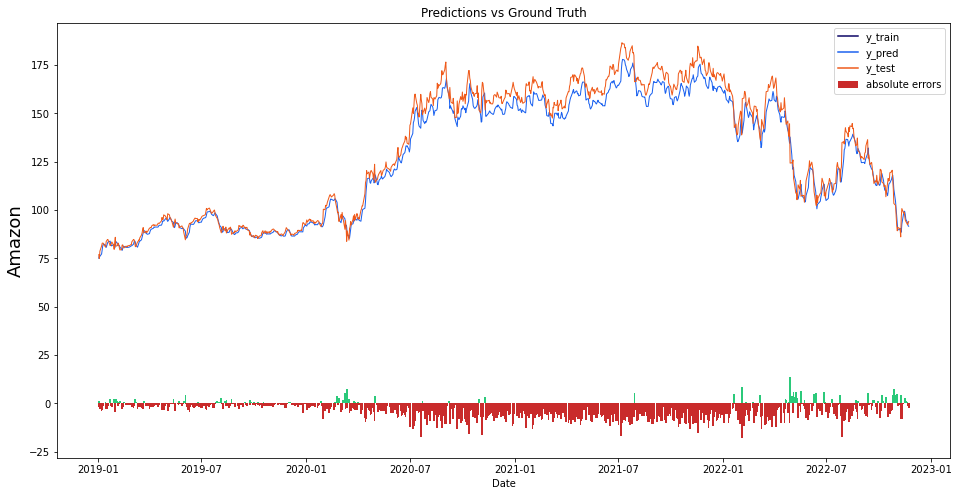

In [45]:
display_start_date = "2019-01-01" 

train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(train_df[train_data_length:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Ground Truth")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

In [46]:
df_new = df.filter(['Close'])

last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

X_test = []
X_test.append(last_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

price_today = round(df_new['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent_change = round((predicted_price * 100)/price_today - 100, 2)

prefix = '+' if percent_change > 0 else ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price for the next day is {predicted_price} ({prefix}{percent_change}%)')

1/1 [==============================] - 1s 718ms/step
The close price for Amazon at 2022-11-24 was 94.13
The predicted close price for the next day is 92.41000366210938 (-1.83%)
